In [2]:
%matplotlib inline
from scipy import ndimage, signal
from skimage.restoration import denoise_nl_means, estimate_sigma
from skimage.morphology import dilation, disk, erosion, opening, closing, square, rectangle
from skimage.filters import *
from skimage.measure import label
from skimage.segmentation import watershed, expand_labels
from skimage.color import label2rgb
import tifffile
import numpy as np
from numpy.fft import fft, fftfreq, ifft, fft2, fftn
import matplotlib.pyplot as plt

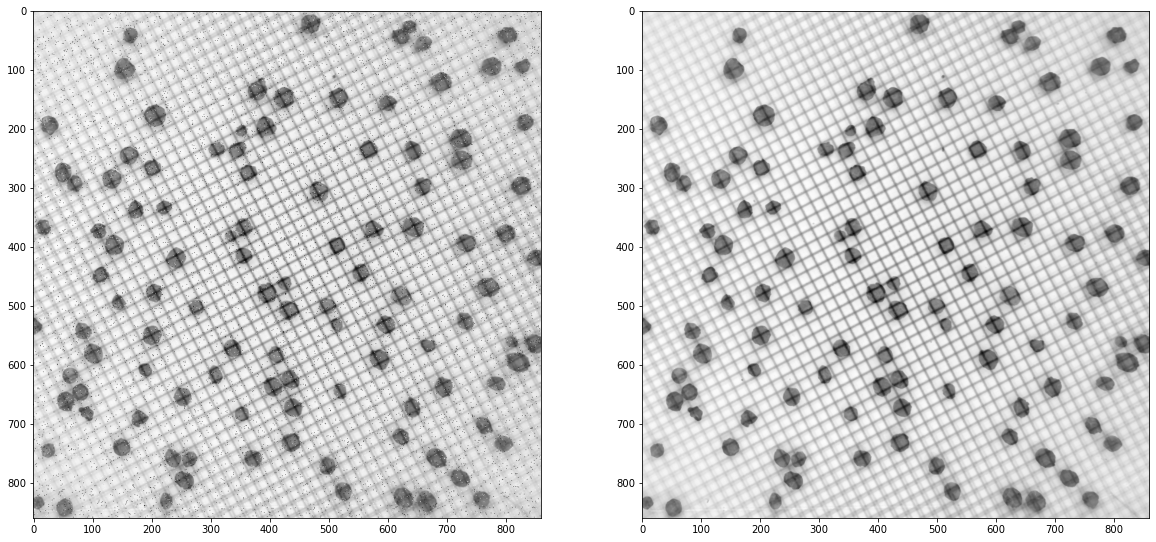

In [3]:
input = tifffile.imread('input.tif')
fig, ax = plt.subplots(ncols=2, figsize=(20, 10))

#Remove salt and petter noise
denoised_image = ndimage.median_filter(input, 3)

ax[0].imshow(input, cmap="gray")
ax[1].imshow(denoised_image, cmap="gray")

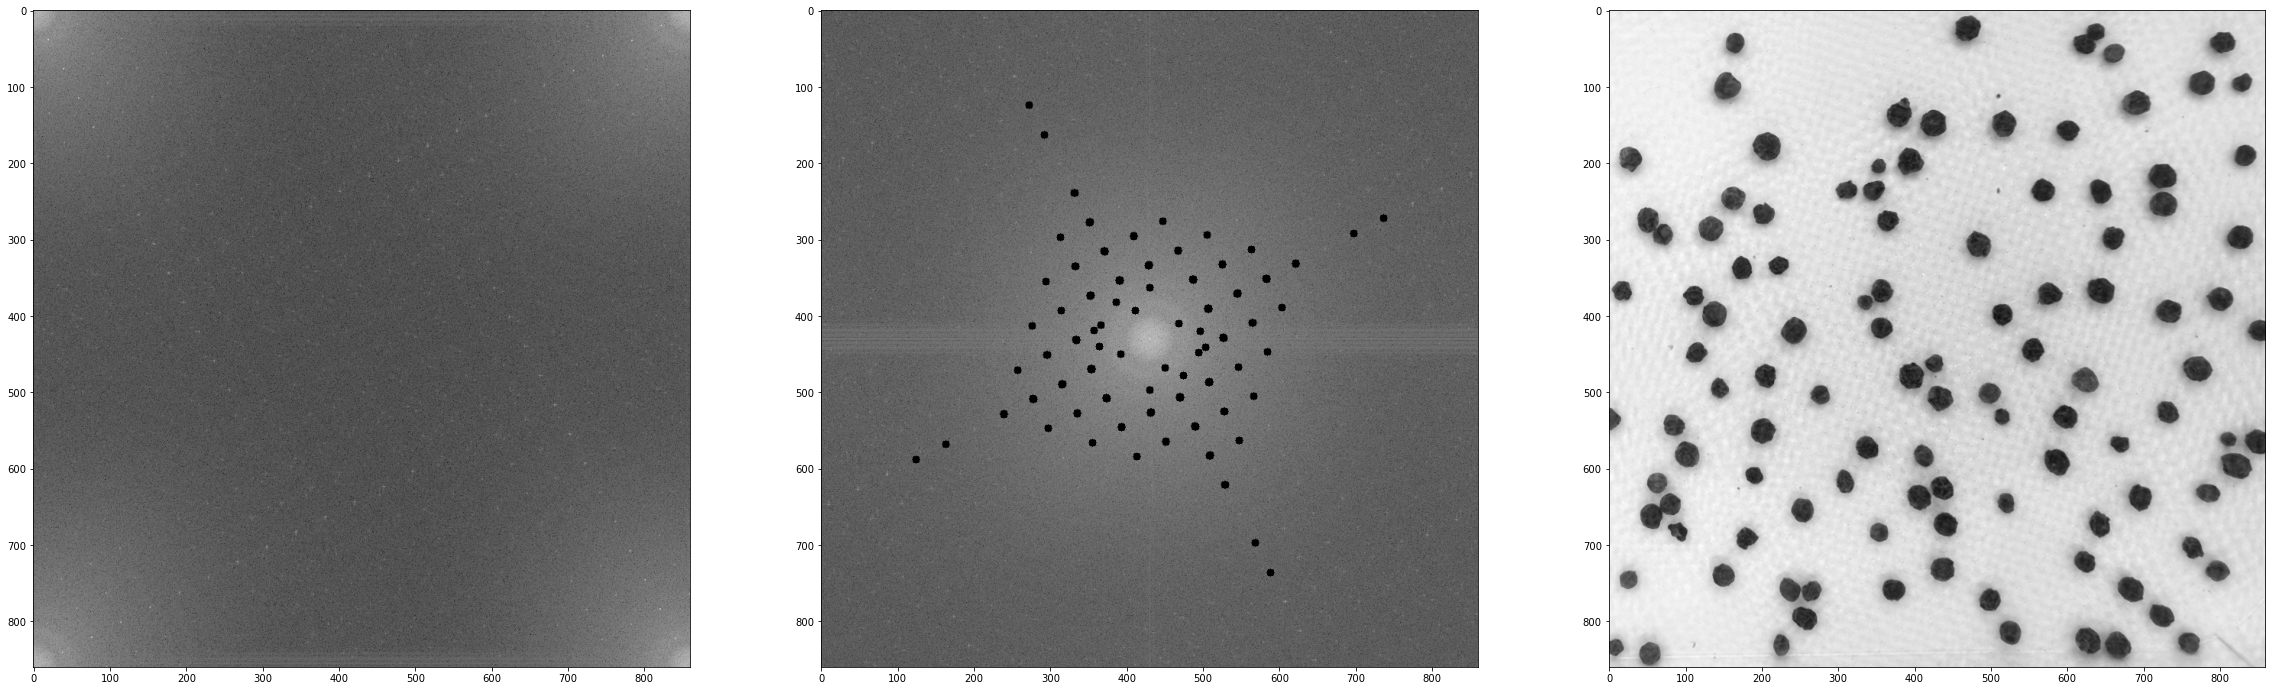

In [4]:
import cv2
from numpy.fft import ifft2




fig, ax = plt.subplots(ncols=3, figsize=(40, 20))

img_c2 = np.fft.fft2(denoised_image)

img_c3 = np.fft.fftshift(img_c2)

#mask = np.zeros([860,860])

#mask[390:470, 390:470] = 1

rows, cols = input.shape
crow, ccol = int(rows / 2), int(cols / 2)

r = 65


mask = np.ones_like(input)


center = [crow, ccol]

x, y = np.ogrid[:rows, :cols]

mask_area = (x - center[0]) ** 2 + (y - center[1]) ** 2 <= r*r

mask[mask_area] = 0


filter = np.abs(img_c3 * mask) < 75000


filter[393, 411] = 0
filter[450, 392] = 0
filter[468, 450] = 0
filter[410, 468] = 0



#print(np.transpose((filter == 0).nonzero()))

filter = erosion(filter, disk(5))






img_c3 = img_c3 * filter

img_c4 = np.fft.ifftshift(img_c3)

img_c5 = np.fft.ifft2(img_c4)

#print(np.transpose(filter == 1))


cv2.imwrite("power_spectrum.png",np.log(1+np.abs(img_c3)))



ax[0].imshow(np.log(1+np.abs(img_c2) ** 2), "gray")
ax[1].imshow(np.log(1+np.abs(img_c3)), "gray")
ax[2].imshow(img_c5.real, "gray")

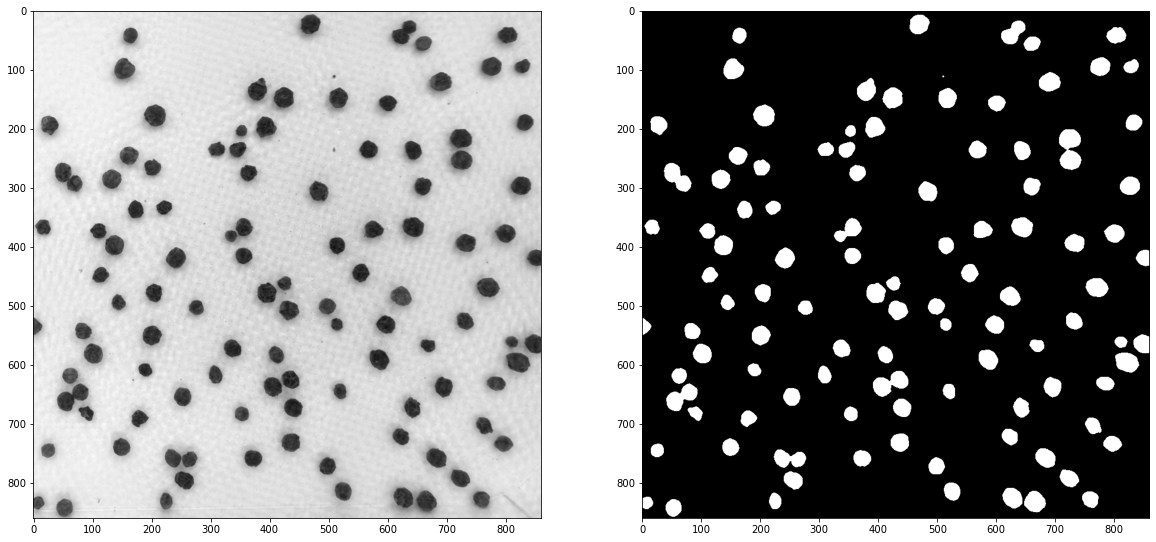

In [92]:
from skimage.exposure import exposure
from scipy.ndimage import median_filter
from skimage.morphology import diamond, octagon, remove_small_objects, star

fig, ax = plt.subplots(ncols=2, figsize=(20, 10))

test  = img_c5.real.astype(int)

footprint = disk(5)
bin_image = test < 150

bin_image = median_filter(bin_image,5)

ax[0].imshow(test, "gray")
ax[1].imshow(bin_image, "gray")

Text(0.5, 1.0, 'Detected Peppercorns')

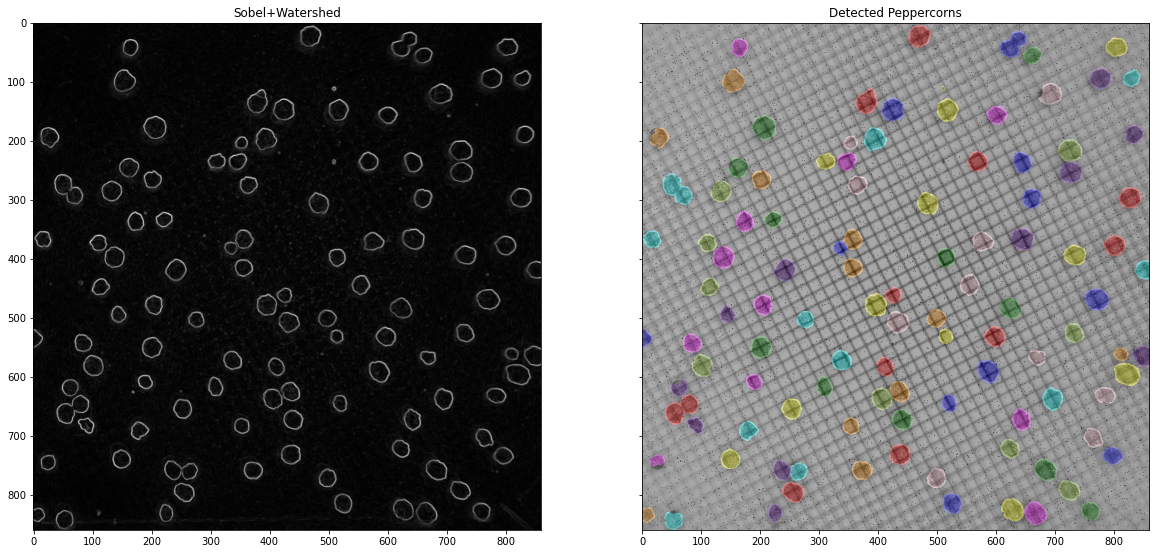

In [26]:
from skimage.feature import canny, peak_local_max

# edge detection
edges = sobel(test)
markers = np.zeros_like(test)
# Identify some background and foreground pixels from the intensity values.
# These pixels are used as seeds for watershed.
foreground, background = 1, 2
markers[test < 120] = foreground
markers[test > 130] = background


ws = watershed(edges, markers)
seg1 = label(ws == foreground)

expanded = expand_labels(seg1, distance=3)

# Show the segmentations.
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10),
                         sharex=True, sharey=True)

color1 = label2rgb(seg1, image=input, bg_label=0)
axes[0].imshow(edges, "gray")
axes[0].set_title('Sobel+Watershed')


color2 = label2rgb(expanded, image=input, bg_label=0)
axes[1].imshow(color2)
axes[1].set_title('Detected Peppercorns')

In [47]:
print("Count of peppercorns: " + str(seg1.max()))

Count of peppercorns: 108


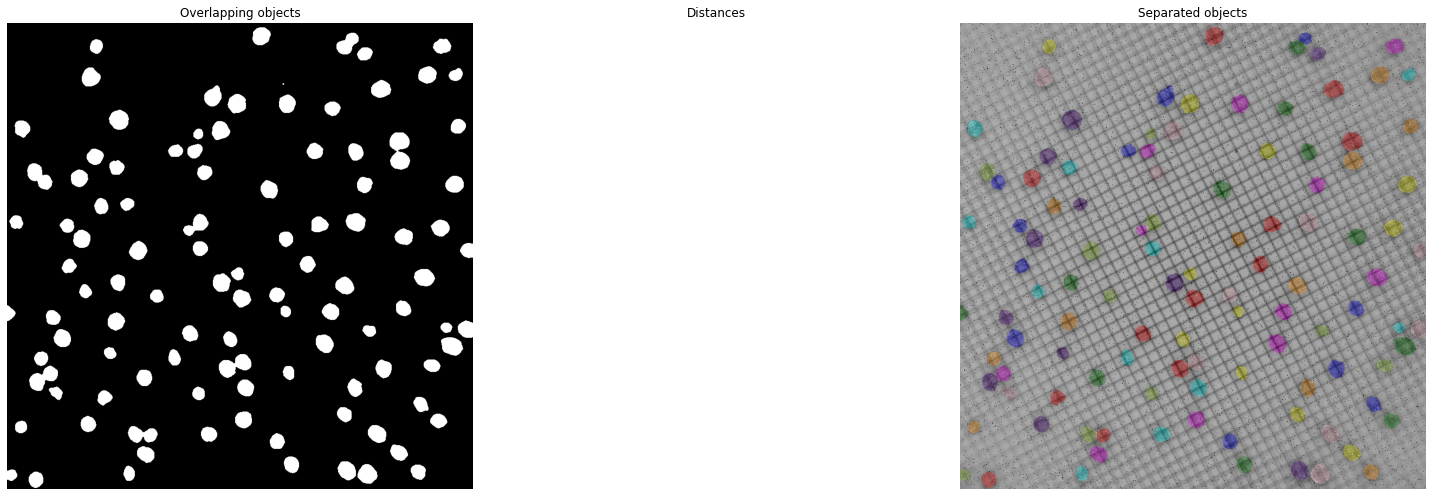

In [93]:
distance = ndimage.distance_transform_edt(bin_image)
coords = peak_local_max(distance, footprint=disk(10), labels=bin_image, min_distance=5)
mask = np.zeros(distance.shape, dtype=bool)
mask[tuple(coords.T)] = True
markers, _ = ndimage.label(mask)
labels = watershed(-distance, markers, mask=bin_image)

color3 = label2rgb(labels, image=input, bg_label=0)

fig, axes = plt.subplots(ncols=3, figsize=(20, 10), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(bin_image, cmap=plt.cm.gray)
ax[0].set_title('Overlapping objects')
ax[1].imshow(-distance, cmap=plt.cm.gray)
ax[1].set_title('Distances')
ax[2].imshow(labels, cmap=plt.cm.nipy_spectral)
ax[2].set_title('Separated objects')
ax[2].imshow(color3)


for a in ax:
    a.set_axis_off()

fig.tight_layout()
plt.show()